![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

## Destination Earth - Climate Change Adaptation Digital Twin Series Plot- Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Climate DT overview (for DESP testing period)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=414254710)

<br>Author: EUMETSAT</br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [13]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import json
import os
from getpass import getpass
import destinelab as deauth

### Query using the DEDL HDA API


First, we get an access token for the API

In [14]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [15]:
auth.is_DTaccess_allowed(access_token)

DT Output access allowed


True

## Filter
We have to setup up a filter and define which data to obtain.

Choose a valid combination of => **Activity + Experiment + Model** (based on the year of interest)

Following **activities/experiment/model** & dates are possible:

ScenarioMIP/ssp3-7.0/ICON: Start date 20200101, 40 years<br> 
ScenarioMIP/ssp3-7.0/IFS-NEMO: Start date 20200101, 40 years<br> 

In [16]:
datechoice = "2028-06-10T00:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed 
        "dataset": "climate-dt",   # fixed climate-dt access
        "activity": "ScenarioMIP", # activity + experiment + model (go together)
        "experiment": "SSP3-7.0",  # activity + experiment + model (go together)
        "model": "IFS-NEMO",       # activity + experiment + model (go together)
        "generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
        "realization": "1",        # fixed Specifies the climate realization. Default 1. Based on perturbations of initial conditions
        "resolution": "high",      # standard/ high 
        "expver": "0001",          # fixed experiment version 
        "stream": "clte",          # fixed climate
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
#        "levelist": "1/2/3/...",  # for ml/pl/sol type data
        "param": "167"             # 2m Temperature parameter
    }.items()
}

## Make Data Request

In [17]:
from tqdm import tqdm
import time
import re
from datetime import datetime
from IPython.display import JSON

#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

# Define date choice and filters if needed
datechoice = "2024-07-01"

# Initialize a list to store filenames
filenames = []

# Define start and end years
start_year = 2024
start_month = 7
end_year = 2028

# Loop 
for year in range(start_year, end_year + 1):
    # Create a datetime object 
    obsdate = datetime(year, start_month, 1)
    datechoice = obsdate.strftime("%Y-%m-%dT12:00:00Z")
    response = session.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
        "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
        "datetime": datechoice,
        "query": filters
    })

    # Requests to EO.ECMWF.DAT.DT_CLIMATE always return a single item containing all the requested data
    # print(response.json())
    product = response.json()["features"][0]

    # DownloadLink is an asset representing the whole product
    download_url = product["assets"]["downloadLink"]["href"]
    print(download_url)
    HTTP_SUCCESS_CODE = 200
    HTTP_ACCEPTED_CODE = 202

    direct_download_url = ''

    response =session.get(download_url, headers=auth_headers)
    response.raise_for_status()
    if (response.status_code == HTTP_SUCCESS_CODE):
        direct_download_url = product['assets']['downloadLink']['href']
    elif (response.status_code != HTTP_ACCEPTED_CODE):
        JSON(response.json(), expanded=True)

    # we poll as long as the data is not ready
    if direct_download_url == '':
        while url := response.headers.get("Location"):
            print(f"order status: {response.json()['status']}")
            response = session.get(url, headers=auth_headers, stream=True)
            response.raise_for_status()

    # Check if Content-Disposition header is present
    if "Content-Disposition" not in response.headers:
        print(response)
        print(response.json())
        raise Exception("Headers: \n"+str(response.headers)+"\nContent-Disposition header not found in response. Must be something wrong.")
    filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
    
    # Add the filename to the list
    filenames.append(filename)


    
    

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20240701_20240701_83b724d2dd1b7706cb8391582868f3ea08a161e9/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220240701%252Fto%252F20240701%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B167%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D
order status: queued
order status: queued
order status: queued
order status: processing
order

100%|██████████| 26.2M/26.2M [00:00<00:00, 56.6MB/s]


https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20250701_20250701_b6fa7817c46cb4c19472364a6f5109848a40b52d/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220250701%252Fto%252F20250701%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B167%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D
order status: processing
order status: processing
order status: processing
downloading 4240e7

100%|██████████| 24.6M/24.6M [00:00<00:00, 56.9MB/s]


https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20260701_20260701_336ea16ea32bb425e1599bc03668ce822a46cc12/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220260701%252Fto%252F20260701%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B167%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D
order status: processing
downloading 782d837e-ad19-411f-9436-40c09fcb1e83.grib


100%|██████████| 26.2M/26.2M [00:00<00:00, 59.2MB/s]


https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20270701_20270701_e4f64c7f8331b3d33a6dcaaa03ddbc39b15dd593/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220270701%252Fto%252F20270701%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B167%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D
order status: queued
order status: queued
order status: processing
order status: processing
d

100%|██████████| 26.2M/26.2M [00:00<00:00, 55.4MB/s]


https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20280701_20280701_3d63a781eb3e389cb90a683a5b0cd0a326ddd22f/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220280701%252Fto%252F20280701%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B167%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D
order status: queued
order status: processing
order status: processing
downloading fd9b2787-2

100%|██████████| 26.3M/26.3M [00:00<00:00, 56.2MB/s]


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [18]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

296f97e6-3808-4b2a-b474-c4820bc55ad6.grib


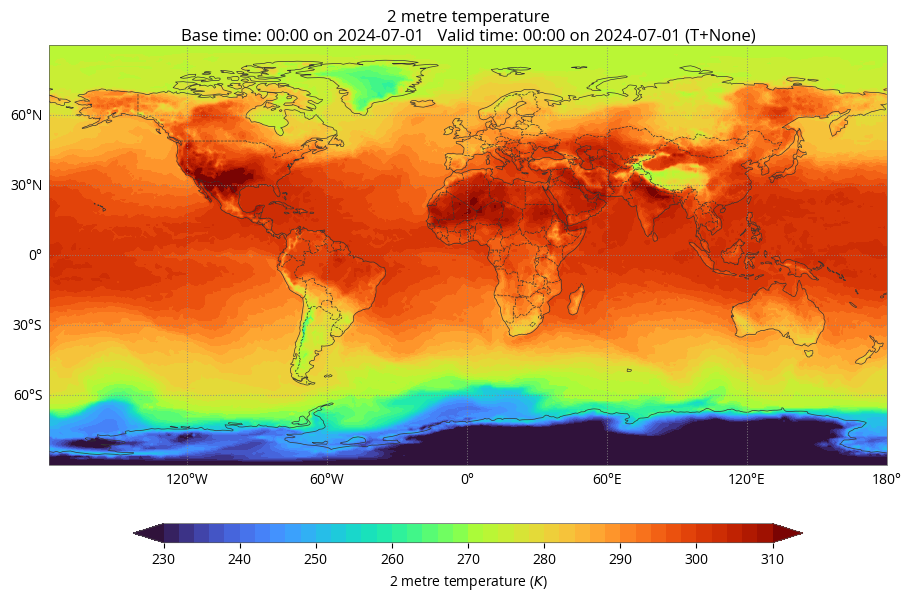

4240e7ed-fca2-40b2-b3c0-ebbac98b6b74.grib


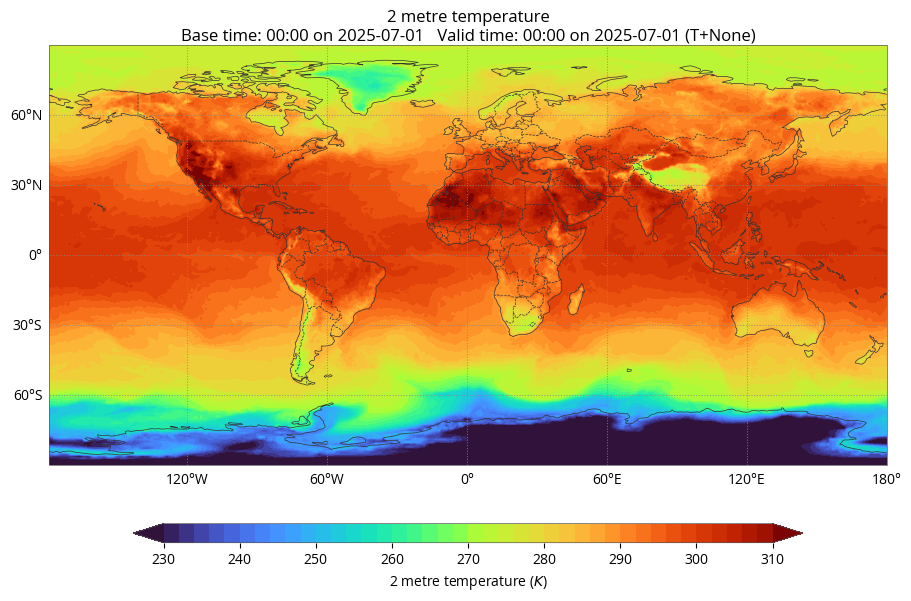

782d837e-ad19-411f-9436-40c09fcb1e83.grib


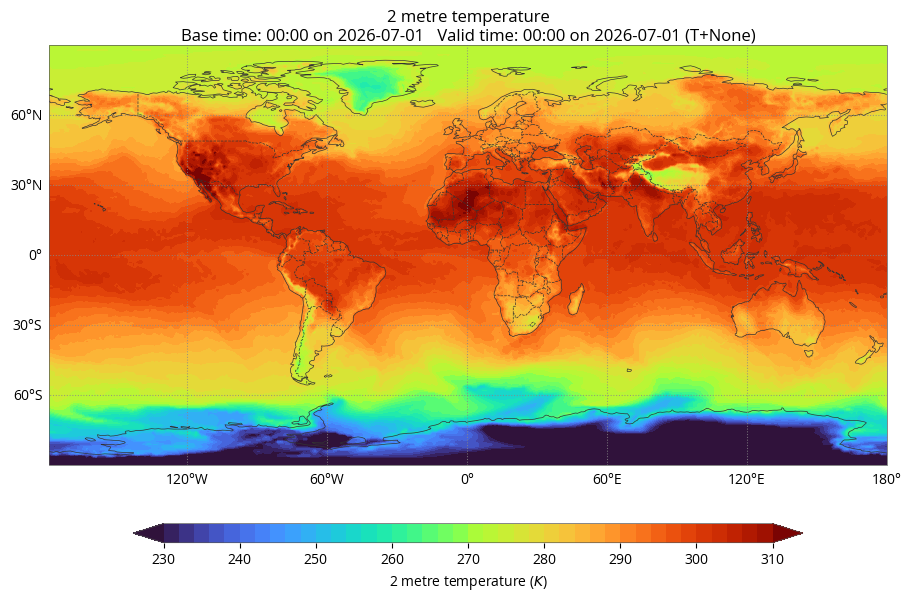

76d1e5b4-6af5-4e4d-8085-5bd1de2bbc03.grib


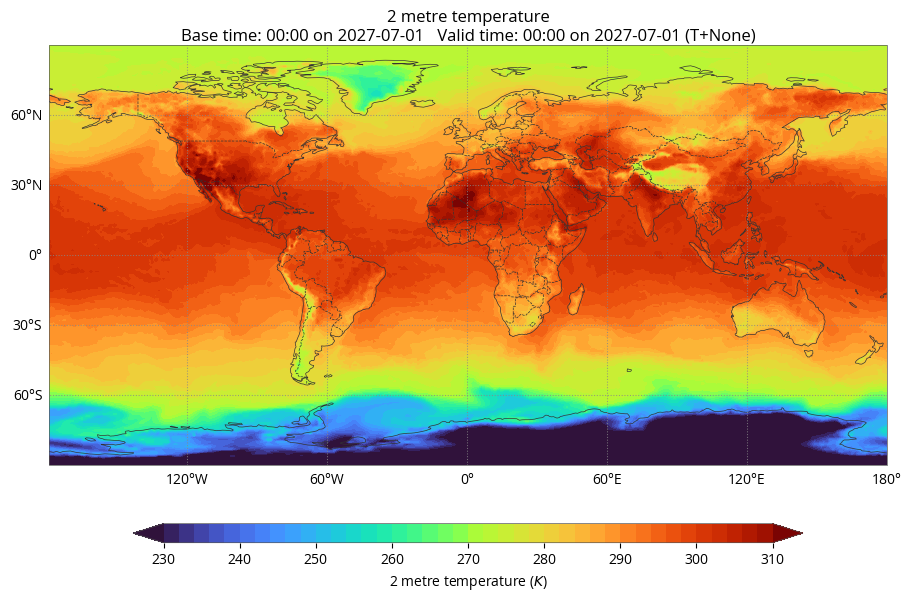

fd9b2787-2b41-4c2e-b090-2ecf7816b5c4.grib


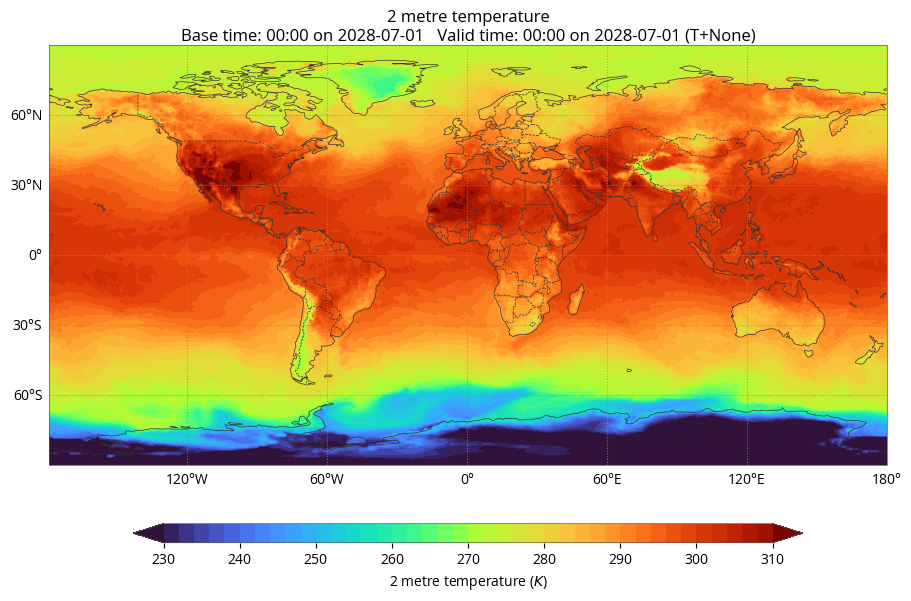

In [19]:
# Iterate over filenames
for filename in filenames:
    print(filename)  # For example, print each filename
    data = earthkit.data.from_source("file", filename)
    data.ls
    earthkit.maps.quickplot(data,#style=style
                       )
